# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

*Images data is wrapped with custom entity to simplify it usage during training, testing and validation.*

In [1]:
import pickle
import csv
from sklearn.utils import shuffle
import os

class TrafficSignsData:

    def __init__(self, data_folder_path="./traffic-signs-data/"):
        training_file = os.path.join(data_folder_path, "train.p")
        validation_file = os.path.join(data_folder_path, "valid.p")
        testing_file = os.path.join(data_folder_path, "test.p")
        sign_names_file = "./signnames.csv"

        with open(training_file, mode='rb') as f:
            train = pickle.load(f)
        with open(validation_file, mode='rb') as f:
            valid = pickle.load(f)
        with open(testing_file, mode='rb') as f:
            test = pickle.load(f)

        self.train_data_set = DataSet(train['labels'], train['features'])
        self.valid_data_set = DataSet(valid['labels'], valid['features'])
        self.test_data_set = DataSet(test['labels'], test['features'])
        self.s_names = TrafficSignNames(sign_names_file)

    def print_info(self):
        print("Number of training examples =", self.train.length)
        print("Number of testing examples =", self.test.length)
        print("Number of validation examples =", self.validation.length)
        print("Number of classes =", len(set(self.train.labels)))
        print("Image data shape = {0[1]}x{0[2]}x{0[3]}".format(self.train.features.shape))

    @property
    def sign_names(self):
        return self.s_names.sign_names

    @property
    def train(self):
        return self.train_data_set

    @property
    def validation(self):
        return self.valid_data_set

    @property
    def test(self):
        return self.test_data_set

In [2]:
class DataSet:

    def __init__(self, labels, features):
        n_l, n_f = len(labels), len(features)
        if n_l != n_f:
            raise Exception("Amount of labels [{}] must be equal to amount of features [{}]".format(n_l, n_f))

        self._f = features
        self._l = labels
        self._classes = len(set(self._l))
        self.offset = 0
        self.current_batch = [], []

    @property
    def length(self):
        return len(self._l)

    @property
    def features(self):
        return self._f

    @property
    def labels(self):
        return self._l

    @property
    def n_classes(self):
        return self._classes

    @property
    def current(self):
        return self.current_batch

    def shuffle(self):
        self._l, self._f = shuffle(self._l, self._f)
        self.reset()

    def apply_map(self, map_func):
        self._l, self._f = map_func(self._l, self._f)
        self.reset()

    def move_next(self, batch_size):
        self.current_batch = self._l[self.offset:self.offset+batch_size], self._f[self.offset:self.offset+batch_size]
        if len(self.current_batch[0]) > 0:
            self.offset = self.offset + batch_size
            return True
        else:
            self.reset()
            return False

    def reset(self):
        self.current_batch = [], []
        self.offset = 0

*Next entity represents mapping between traffic sign classes and traffic sing names:*

In [3]:
class TrafficSignNames:

    def __init__(self, csv_file_path="./signnames.csv"):

        with open(csv_file_path) as f:
            self.s_names_dict = {}
            read_csv = csv.reader(f, delimiter=",")
            for index, row in enumerate(read_csv):
                if index > 0:
                    self.s_names_dict[int(row[0])] = row[1]

    @property
    def sign_names(self):
        return self.s_names_dict


---

## Step 1: Dataset Summary & Exploration


*Data loading and basic data information output:*

In [5]:
data = TrafficSignsData()
data.print_info()

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Number of classes = 43
Image data shape = 32x32x3


*Here is some code helpers for visialization:*

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Visualizations will be shown in the notebook.
%matplotlib inline

def plot_image(image, caption="no caption"):
    fig, ax = plt.subplots()
    fig.suptitle(caption, fontweight="bold")
    plt.imshow(image)
    plt.show()

def visualize_labels_state(data_set):
    labels, n_classes = data_set.labels, data_set.n_classes
    n_label_classes = len(set(labels))
    
    fig, ax = plt.subplots()
    fig.suptitle("Labels amount", fontweight="bold")
    fig.set_size_inches(15, 6)

    ax.hist(labels, 86, facecolor="green", alpha=0.75)
    ax.set_xticks(np.arange(0, n_classes), 1.0)
    ax.xaxis.grid(which="both")

    plt.xlabel("traffic sign label")
    plt.ylabel("amount of samples")
    plt.xticks(np.arange(0, n_label_classes, 1.0))
    plt.grid()
    plt.show()

    
def visualize_labels_distribution(data_set):
    labels = data_set.labels
    n_label_classes = len(set(labels))
    
    fig, ax = plt.subplots()
    fig.suptitle("Labels distribution", fontweight="bold")
    fig.set_size_inches(15, 6)

    ax.plot(labels, range(len(labels)), "b.", alpha=0.75)
    ax.set_xticks(np.arange(0, n_label_classes), 1.0)
    ax.xaxis.grid(which="both")

    plt.ylabel("index")
    plt.xlabel("traffic sign label")
    plt.xticks(np.arange(0, n_label_classes, 1.0))
    plt.grid()
    plt.show()

    
def visualize_random_sign(data_set, s_names_dict):
    labels, images = data_set.labels, data_set.features
    n_images = len(images)
    rnd_sign_index = np.random.randint(0, n_images)
    rnd_sign_class = labels[rnd_sign_index]
    caption = "Class: {}, {}. Item No.{}".format(rnd_sign_class, s_names_dict[rnd_sign_class], rnd_sign_index)

    plot_image(images[rnd_sign_index], caption)

    
def visualize_accuracy(data_set):
    fig, ax = plt.subplots()
    fig.suptitle("validation accuracy, max value {:.4f}%".format(max(data_set[1])*100), fontweight="bold")
    fig.set_size_inches(15, 6)

    ax.plot(data_set[0], data_set[1], "g", alpha=0.75)

    plt.ylabel("accuracy")
    plt.xlabel("processed images")
    plt.show()
    

*And the some basic visualization of testing data:*

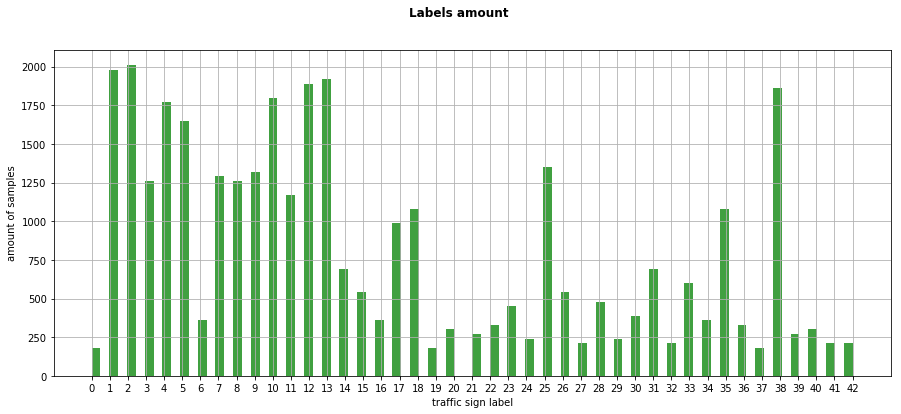

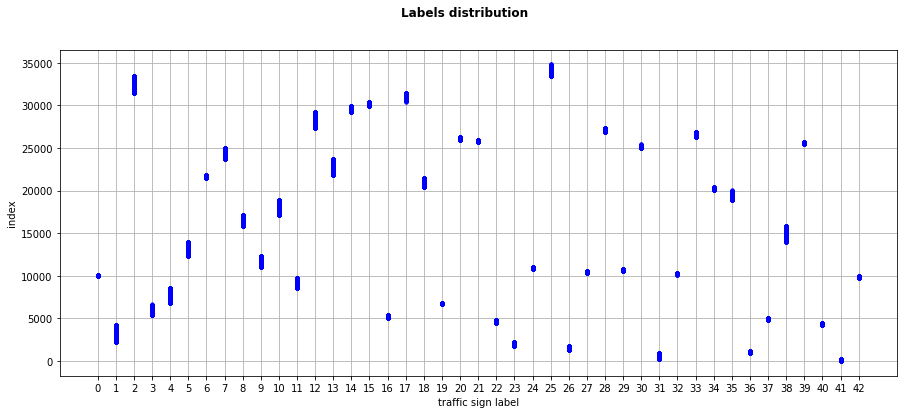

In [6]:
visualize_labels_state(data.train)
visualize_labels_distribution(data.train)

Some conclusions: 

   - Ratio between amount of images of one type and amount of images of another type can be up to 10 times. 
   - Input images are not shuffled.

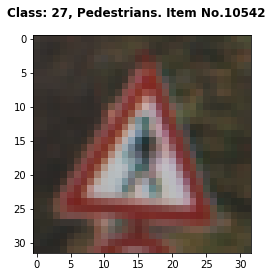

In [7]:
visualize_random_sign(data.train, data.sign_names)

----

## Step 2: Design and Test a Model Architecture

For this work I'm using the LeNet-5 implementation with the next structure:

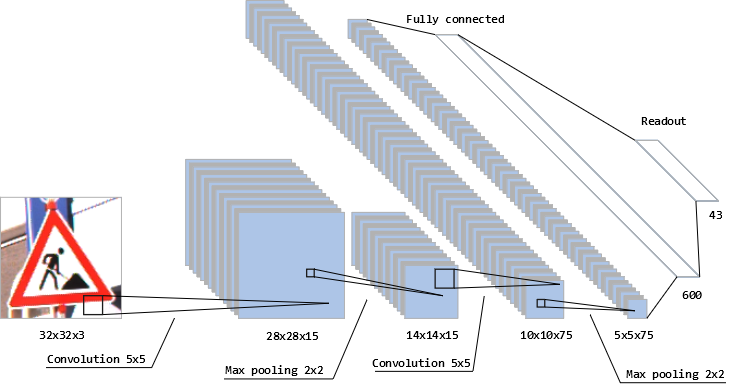

- I'm using dropout technique to reduce overfitting. Dropout is applied to all network layers except of the very last one - linear readout.
- I have also tried suggested normalization `(color_channel - 128) / 128` and different color scheme (HSV instead of RGB) but have not noticed significant accuracy improvement. So I sticked to simplier code.
- Number of examples for different sign type in training set varies from 180 to 2010 images. I have assumed normalized training set to have better results, but this assumption was wrong. Accuracy on full set with low dropout grows faster and it is more stable with increasing epochs amount.
- At the end I noticed one more problem. Neural network cannot recognize non traffic sign images. I have couple of ideas to solve it. One solution could be additional class for non traffic sing input. Then training set needs to be extended with some fake data. On the other hand, this problem can be solved with another neural network, or other image analysis technique, not yet known to me. Due to lack of time I have not tried the first option.

Model also includes configured TensorFlow tool for tracking learning process called [**TensorBoard**](https://www.tensorflow.org/get_started/summaries_and_tensorboard). It saves model structure, logs defined data to analize if everything goes as expected. And the most useful feature to me as a newbie was comparing result. 

Here is screenshot of my graph from TensorBoard:
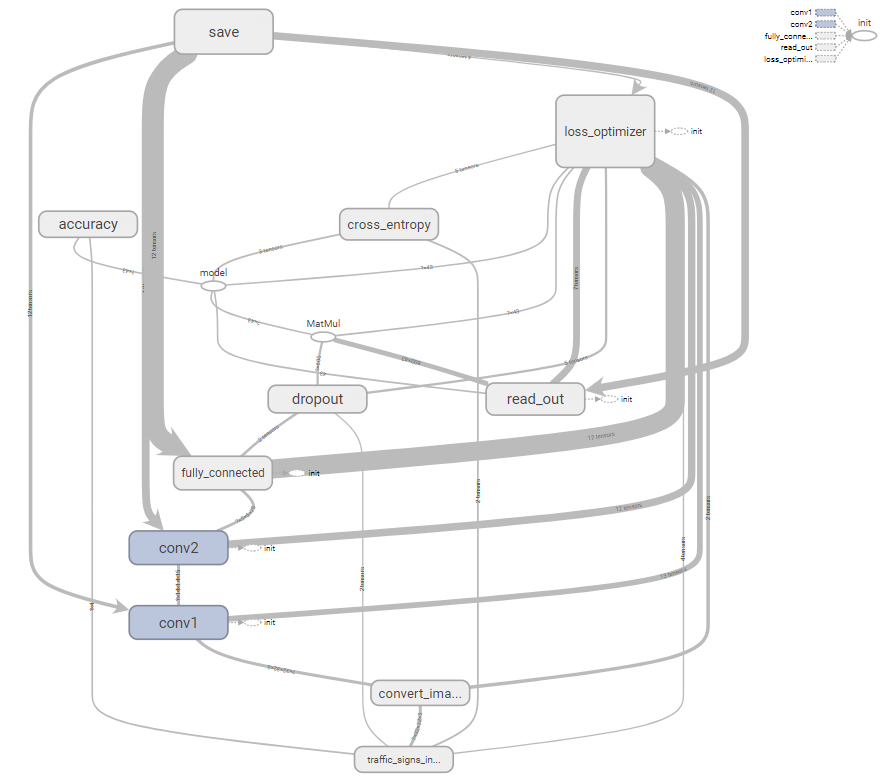

Screenshots of loss and accuracy:
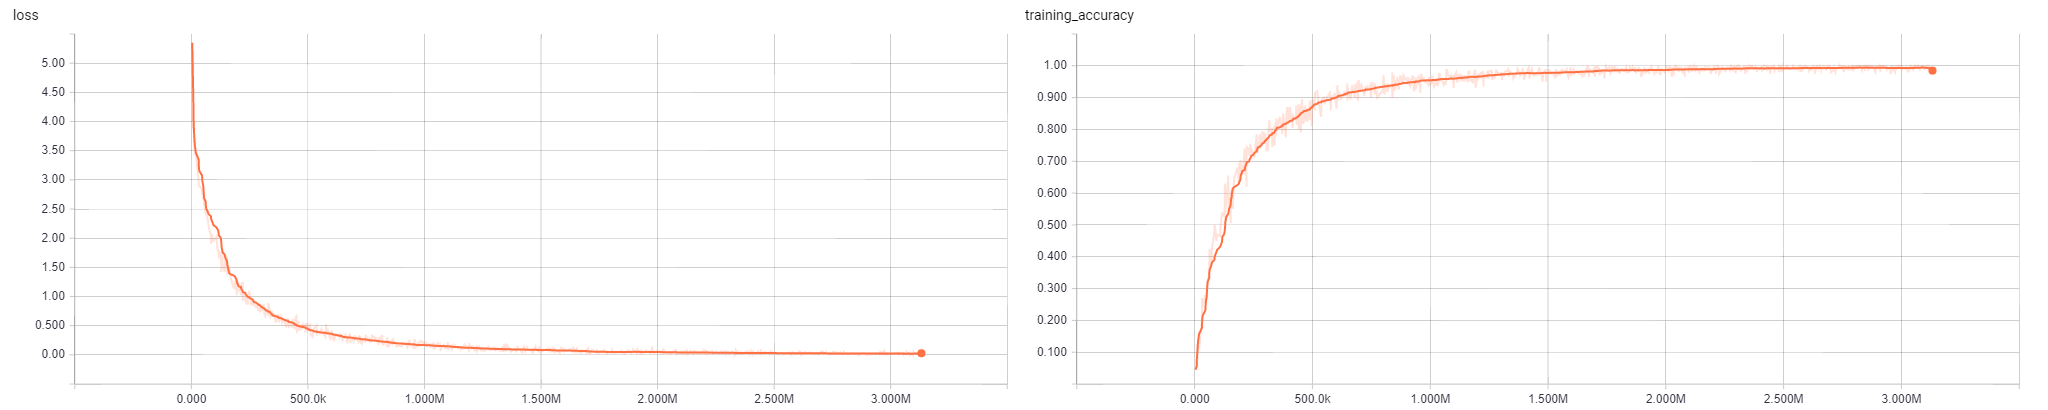

My submission does not include tensorboard log file because of its size.

### Pre-process the Data Set (normalization, grayscale, etc.)

Next data preprocessing steps are used in current solution:
 - data is shuffled before each epoch
 - images data type converted to float32 - `output = tf.image.convert_image_dtype(input, dtype=tf.float32)`

In [8]:
### Preprocess the data here

data.train.shuffle()

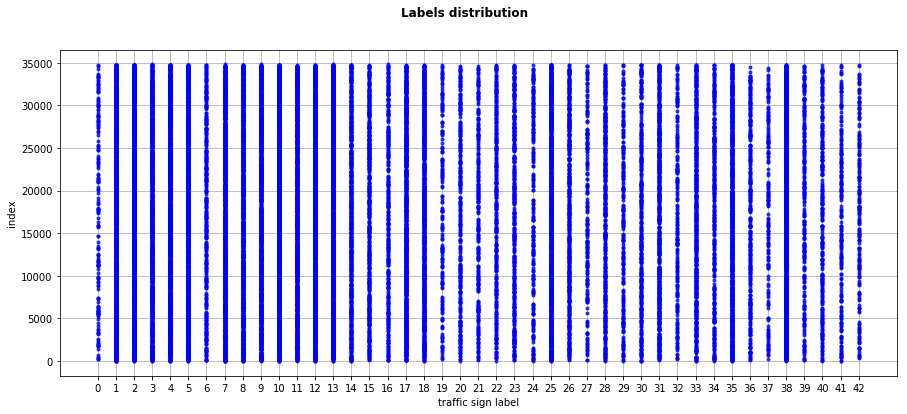

In [9]:
visualize_labels_distribution(data.train)

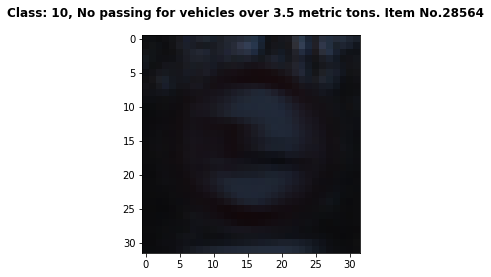

In [10]:
visualize_random_sign(data.train, data.sign_names)

### Model Architecture

*The neural network implementation:*

In [5]:
import tensorflow as tf


class NnModelFactory:

    @staticmethod
    def _weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name="weight")

    @staticmethod
    def _bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name="bias")

    @staticmethod
    def _conv2d(x, w):
        return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding="VALID", name="conv2d")

    @staticmethod
    def _max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID", name="max_pool")

    def create(self, input_tensor, keep_prob_tensor, n_classes):
        with tf.name_scope("conv1"):
            w_conv1 = self._weight_variable([5, 5, 3, 15])
            b_conv1 = self._bias_variable([15])
            conv1_wx_b = self._conv2d(input_tensor, w_conv1) + b_conv1

            conv1 = tf.nn.relu(conv1_wx_b, name="relu")
            # Convolution output is 28x28x15
            pool1 = self._max_pool_2x2(conv1)
            # Pooling output is 14x14x15

        with tf.name_scope("conv2"):
            w_conv2 = self._weight_variable([5, 5, 15, 75])
            b_conv2 = self._bias_variable([75])
            conv2_wx_b = self._conv2d(pool1, w_conv2) + b_conv2

            conv2 = tf.nn.relu(conv2_wx_b, name="relu")
            # Convolution output is 10x10x75
            pool2 = self._max_pool_2x2(conv2)
            # Pooling output is 5x5x75

        with tf.name_scope("fully_connected"):
            w_fc1 = self._weight_variable([5 * 5 * 75, 600])
            b_fc1 = self._bias_variable([600])

            pool2_flat = tf.reshape(pool2, [-1, 5 * 5 * 75], name="pool")
            fc1 = tf.nn.relu(tf.matmul(pool2_flat, w_fc1) + b_fc1, name="relu")

        # dropout
        fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob_tensor, name="dropout")

        # readout
        with tf.name_scope("read_out"):
            w_fc2 = self._weight_variable([600, n_classes])
            b_fc2 = self._bias_variable([n_classes])

        # model
        return tf.add(tf.matmul(fc1_drop, w_fc2), b_fc2, name="model")


And here is the training infrastructure:

*Separate entity with network input parameters:*

In [6]:
class Placeholders:

    def __init__(self, im_shape):
        t_images_shape = list(im_shape)
        t_images_shape.insert(0, None)
        self.t_images = tf.placeholder(tf.uint8, t_images_shape, name="input_images")
        self.t_labels = tf.placeholder(tf.int32, (None,), name="input_labels")
        self.t_keep_prob = tf.placeholder(tf.float32, name="keep_prob")

    @property
    def labels_tensor(self):
        return self.t_labels

    @property
    def images_tensor(self):
        return self.t_images

    @property
    def keep_prob_tensor(self):
        return self.t_keep_prob

    def create_feed(self, labels_data, images_data, keep_prob=1.0):
        return {
            self.t_labels: labels_data,
            self.t_images: images_data,
            self.t_keep_prob: keep_prob
        }
    

*Training infrastructure which ties together model input, model, optimization and exposes outside some useful training cycle steps:*

In [7]:
class NnModelTrainer:

    def __init__(self, im_shape, n_classes, learning_rate=0.0001):

        with tf.name_scope("traffic_signs_input"):
            self.t_input = Placeholders(im_shape)
            t_one_hot_labels = tf.one_hot(self.input.labels_tensor, n_classes, name="one_hot_labels")

        with tf.name_scope("input"):
            tf.summary.image("images", self.input.images_tensor, 5)

        t_preprocessed_images = tf.image.convert_image_dtype(self.input.images_tensor, dtype=tf.float32)
        self.t_logits = NnModelFactory().create(t_preprocessed_images, self.input.keep_prob_tensor, n_classes)

        with tf.name_scope("cross_entropy"):
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=t_one_hot_labels, logits=self.t_logits)
            self.t_loss = tf.reduce_mean(cross_entropy)

        with tf.name_scope("accuracy"):
            prediction_is_correct = tf.equal(tf.argmax(self.t_logits, 1), tf.argmax(t_one_hot_labels, 1))
            self.t_accuracy = tf.reduce_mean(tf.cast(prediction_is_correct, tf.float32))

        with tf.name_scope("loss_optimizer"):
            self.t_train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.t_loss)

    @property
    def input(self):
        return self.t_input

    @property
    def accuracy(self):
        return self.t_accuracy

    @property
    def train_step(self):
        return self.t_train_step

    @property
    def loss(self):
        return self.t_loss

    @property
    def logits(self):
        return self.t_logits


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

*Here are the global training parameters:*

In [8]:
learning_rate = 1e-4
EPOCHS = 90
BATCH_SIZE = 200
# keep_prob parameter for dropout tensor
drop = 0.3
tb_log_path = "./tb_logs/E{}_B{}_R{}_D{}_all-data/".format(EPOCHS, BATCH_SIZE, learning_rate, drop)
model_path = tb_log_path + "model.ckpt"


*Training infrastructure initialization:*

In [15]:
trainer = NnModelTrainer([32, 32, 3], data.train.n_classes, learning_rate)

tf.summary.scalar("loss", trainer.loss)
tf.summary.scalar("training_accuracy", trainer.accuracy)
summarize_all = tf.summary.merge_all()


*The training process itself:*

>**Note:** **You can skip next 2 steps if you don't want to train the model on you environment.**
Project includes trained model whith corresponds to jupyter notebook code on 100%. So it can be used for next steps.

>**Important:** Supplied model was trained on Tensorflow vesion **1.3.0** (suggested environment configurations environment(-gpu).yml in **CarND-Term1-Starter-Kit** have different version, but I failed to install required gpu version on my Windows machine). So model is unlikely to work on Tensorflow lower than 1.3.0

In [16]:
import time


def start_training():
    images_total = EPOCHS * data.train.length
    index = 0
    accuracy_calc_period = 10000
    threshold = accuracy_calc_period
    v_accuracy = 0
    accuracy_log = [], []
        
    start_time = time.time()
    saver = tf.train.Saver()

    with tf.Session() as session:

        session.run(tf.global_variables_initializer())
        tb_writer = tf.summary.FileWriter(tb_log_path, session.graph)

        def evaluate_accuracy(dataset):
            total_accuracy = 0
            while dataset.move_next(BATCH_SIZE):
                labels, images = dataset.current
                a_feed_dict = trainer.input.create_feed(labels, images)

                calculated_accuracy = session.run(trainer.accuracy, feed_dict=a_feed_dict)
                total_accuracy += (calculated_accuracy * len(images))

            return total_accuracy / dataset.length

        
        for epoch in range(EPOCHS):
            data.train.shuffle()

            while data.train.move_next(BATCH_SIZE):
                labels_batch, images_batch = data.train.current
                t_feed_dict = trainer.input.create_feed(labels_batch, images_batch, drop)

                _, summary = session.run([trainer.train_step, summarize_all], feed_dict=t_feed_dict)

                index += len(images_batch)
                if index/threshold > 1:
                    threshold += accuracy_calc_period
                    v_accuracy = evaluate_accuracy(data.validation)
                    accuracy_log[0].append(index)
                    accuracy_log[1].append(v_accuracy)

                print("", end="\r")
                print("Epoch {} [{:.2f}%] Accuracy {:.3f}".format(epoch, (index*100)/images_total, v_accuracy), end="")
                tb_writer.add_summary(summary, index)

        final_accuracy = evaluate_accuracy(data.validation)
        saver.save(session, model_path)

    elapsed = (time.time() - start_time)
    final_accuracy_msg = "Final validation accuracy {:.3f}%".format(final_accuracy * 100)
    spent_time_msg = "Total training time for {} samples: {:.2f} min".format(index, elapsed/60)

    log_data = [
        time.strftime("%X %x"),
        "tensorflow version: " + tf.__version__,
        "",
        final_accuracy_msg,
        "-" * 30,
        spent_time_msg,
        "Samples in batch: \t{}".format(data.train.length),
        "Batches: \t\t\t{:.2f}".format(index/data.train.length),
        "Training dropout: \t{}".format(drop),
        "Learning rate \t\t{}".format(learning_rate)
    ]

    with open("{}_summary_{:.3f}.txt".format(tb_log_path, final_accuracy * 100), "w") as f:
        f.write("\n".join(log_data))

    print()
    print("-" * 30)
    print(final_accuracy_msg)
    print(spent_time_msg)
    visualize_accuracy(accuracy_log)

started
Tensorboad files and model checkpoint location is:  ./tb_logs/E90_B200_R0.0001_D0.3_all-data/
Epoch 89 [100.00%] Accuracy 0.956
------------------------------
Final validation accuracy 95.760%
Total training time for 3131910 samples: 8.94 min


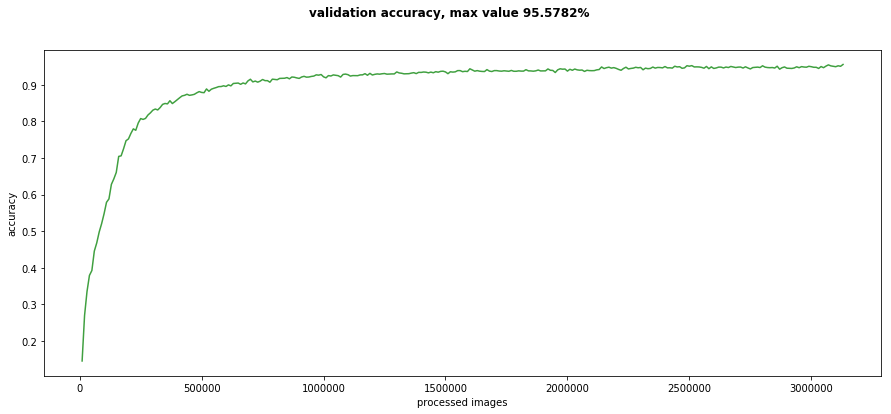

In [17]:
print("started")
print("Tensorboad files and model checkpoint location is: ", tb_log_path)

start_training()

*The graph above shows dependency of validation accuracy on processed training images amount*

---
**Accuracy measurement results**

*Here is the code for accuracy measurement for validation and test data that against previously trained model:*

In [10]:
tf.reset_default_graph()

# I'm going to load model saved during training
model_path = model_path

data = TrafficSignsData()

n_classes = len(data.sign_names)
trainer = NnModelTrainer([32, 32, 3], n_classes)
saver = tf.train.Saver()


def evaluate_accuracy_for(test_data):
    total_accuracy = 0

    with tf.Session() as session:
        saver.restore(session, model_path)

        while test_data.move_next(200):
            labels, images = test_data.current
            feed_dict = trainer.input.create_feed(labels, images)

            calculated_accuracy = session.run(trainer.accuracy, feed_dict=feed_dict)
            total_accuracy += (calculated_accuracy * len(images))

        return total_accuracy / test_data.length


v_accuracy = evaluate_accuracy_for(data.train)
print("Training accuracy is: {:.3f}%".format(v_accuracy*100))    
    
v_accuracy = evaluate_accuracy_for(data.validation)
print("Validation accuracy is: {:.3f}%".format(v_accuracy*100))

t_accuracy = evaluate_accuracy_for(data.test)
print("Test accuracy is: {:.3f}%".format(t_accuracy*100))

INFO:tensorflow:Restoring parameters from ./tb_logs/E90_B200_R0.0001_D0.3_all-data/model.ckpt
Training accuracy is: 99.997%
INFO:tensorflow:Restoring parameters from ./tb_logs/E90_B200_R0.0001_D0.3_all-data/model.ckpt
Validation accuracy is: 95.760%
INFO:tensorflow:Restoring parameters from ./tb_logs/E90_B200_R0.0001_D0.3_all-data/model.ckpt
Test accuracy is: 94.553%


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

*Next piece of code draws all images from **`"./test_signs"`** folder:*

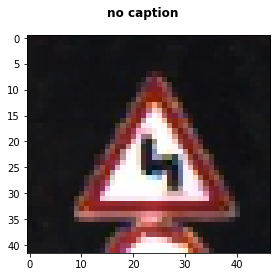

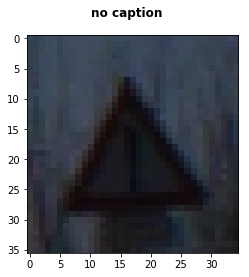

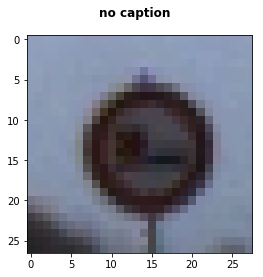

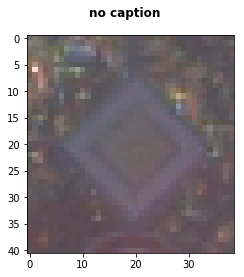

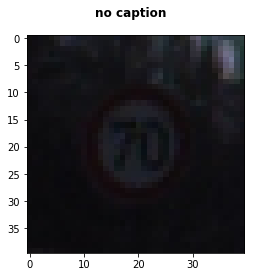

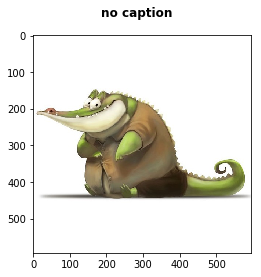

In [9]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_images_dir = "./test_signs"


def git_test_signs():
    return [ test_images_dir + "/" + i for i in os.listdir(test_images_dir)]


for test_image_path in git_test_signs():
    plot_image(mpimg.imread(test_image_path))

### Predict the Sign Type for Each Image

*Here is code for custom image recognition.*

*It takes image, passes it through trained neural network, maps resulting probabilities to appropriate traffic sign class names and sorts results by probabilities.*

In [10]:
import cv2
import operator


class SignReader:

    def __init__(self, t_model_path):
        self.images_shape = [32, 32, 3]
        self.model_path = t_model_path

        self.s_names = TrafficSignNames().sign_names
        self.trainer = NnModelTrainer(self.images_shape, len(self.s_names))
        self.saver = tf.train.Saver()

    @property
    def sign_names(self):
        return self.s_names

    def test(self, input_image):

        for i, dimension in enumerate(self.images_shape):
            if input_image.shape[i] != dimension:
                err_msg = "Input image shape expected to be {}, but was {}".format(self.images_shape, input_image.shape)
                raise Exception(err_msg)

        labels = list(self.s_names.keys())
        images = [input_image]

        with tf.Session() as session:
            self.saver.restore(session, self.model_path)
            feed_dict = self.trainer.input.create_feed(labels, images)

            nn_output = session.run(tf.nn.softmax(self.trainer.logits), feed_dict=feed_dict)[0]
            
            sign_names_with_probabilities = [(s_name, nn_output[key]) for key, s_name in self.sign_names.items()]
            return sorted(sign_names_with_probabilities, key=lambda x: x[1], reverse=True)


*And custom image recognition itself. All images from **`"./test_signs"`** folder will be displayed with highest probability caption and top 5 probabilities list.*

*The code below describe ideal case when traffic sign has ~square shape, traffic sign is at the center and takes major part of the image. So it resizes input image to 32x32 size to pass through trained neural network.*

INFO:tensorflow:Restoring parameters from ./tb_logs/E90_B200_R0.0001_D0.3_all-data/model.ckpt
------------------------------
 99.998188 	 Double curve
 0.001805 	 Wild animals crossing
 0.000007 	 Dangerous curve to the left
 0.000000 	 Right-of-way at the next intersection
 0.000000 	 Road narrows on the right


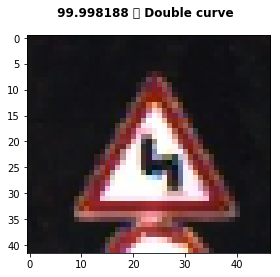

INFO:tensorflow:Restoring parameters from ./tb_logs/E90_B200_R0.0001_D0.3_all-data/model.ckpt
------------------------------
 92.230690 	 General caution
 4.975171 	 Beware of ice/snow
 1.223203 	 Dangerous curve to the right
 0.453468 	 Right-of-way at the next intersection
 0.382782 	 Traffic signals


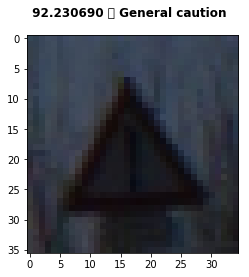

INFO:tensorflow:Restoring parameters from ./tb_logs/E90_B200_R0.0001_D0.3_all-data/model.ckpt
------------------------------
 99.999905 	 No passing for vehicles over 3.5 metric tons
 0.000098 	 Speed limit (80km/h)
 0.000002 	 Speed limit (100km/h)
 0.000001 	 No passing
 0.000001 	 Vehicles over 3.5 metric tons prohibited


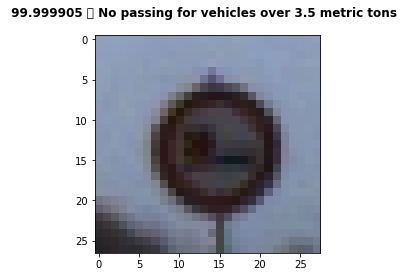

INFO:tensorflow:Restoring parameters from ./tb_logs/E90_B200_R0.0001_D0.3_all-data/model.ckpt
------------------------------
 54.914463 	 Priority road
 36.526901 	 Speed limit (50km/h)
 2.243214 	 Speed limit (30km/h)
 2.074297 	 Roundabout mandatory
 1.033213 	 Yield


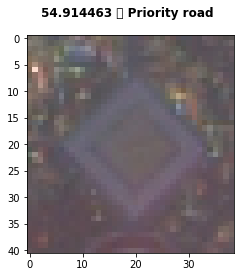

INFO:tensorflow:Restoring parameters from ./tb_logs/E90_B200_R0.0001_D0.3_all-data/model.ckpt
------------------------------
 99.779874 	 Speed limit (70km/h)
 0.161928 	 Speed limit (120km/h)
 0.030254 	 Speed limit (80km/h)
 0.015735 	 Speed limit (100km/h)
 0.008550 	 Speed limit (30km/h)


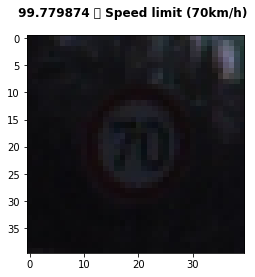

INFO:tensorflow:Restoring parameters from ./tb_logs/E90_B200_R0.0001_D0.3_all-data/model.ckpt
------------------------------
 57.572645 	 Priority road
 29.701543 	 Right-of-way at the next intersection
 7.705513 	 End of speed limit (80km/h)
 3.749631 	 Wild animals crossing
 0.649604 	 Speed limit (60km/h)


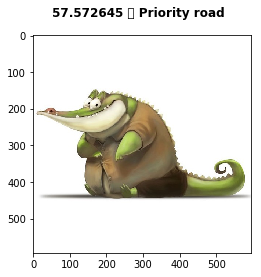

In [11]:
tf.reset_default_graph()

# I'm going to load model saved during training
model_path = model_path
reader = SignReader(model_path)

for test_sign_path in git_test_signs():
    raw_image = mpimg.imread(test_sign_path)
    resized_image = cv2.resize(raw_image, (32, 32))

    top_items = reader.test(resized_image)[:5]

    print("-"*30)
    probabilities = [" {:.6f} \t {}".format(prob * 100, name) for name, prob in top_items]
    print("\n".join(probabilities))

    plot_image(raw_image, probabilities[0])

### Analyze Performance

Model has recognized all random traffic sing images from **German Traffic Sign Benchmarks** *([`GTSRB_Final_Test_Images`](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Downloads))* successfully. It can be verified visually.

It I did not tie concrete images with classes programmatically on purpose. Current implementation is more generic and it works with any input image. User can put any image into `"./test_signs"` folder and just rerun couple of sections to check the result.

Each image recognition result also includes top 5 probabilities with appropriate human readable sign names.

For experement I've added image that has nothing to do with traffic sign. Because model is trained to recognize only between traffic sing classes, fake image was also classified. Which is totally wrong. I have described possible ways of solvin it in model description section.

**Summary**

This project gave me good understanding of how neural networks work and what they can be used for. Also I earned some knowledge about different neural network architectures and some new terminology. I got acquainted with TensorFlow framework, managed to configure my PC to run neural network operations on GPU. And finally I finished traffic sign classifier project. I understand that this project not going to survive real environment challenges, but it might be a good point to start from.